<a href="https://colab.research.google.com/github/coding-geek21/BPN_and_FCM_Soft_Computing/blob/master/Fuzzy_C_means_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fuzzy C Means Clustering on Iris Dataset**

### **Objective:**
#### To implement Fuzzy C means clustering on Iris Species dataset and visualize thhe clusters 

## **Steps Involved**

1.   Initialize the parameters
2.   Find the initial membership matrix
3.   Find the initial cluster center
4.   Find the distance for each datapoints
5.   update the membership matrix
6.   Repeat this untill max iterations reached



### **Loading modules and training data**

In [ ]:
import pandas as pd # reading all required header files
import numpy as np
import random
import operator
import math
import matplotlib.pyplot as plt 
from scipy.stats import multivariate_normal     # for generating pdf

In [ ]:
df_full = pd.read_csv("Iris.csv") 

In [ ]:
df_full.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [ ]:
df_full = df_full.drop(['Id'], axis=1)

In [ ]:
df_full.shape

(150, 5)

In [ ]:
columns = list(df_full.columns)
features = columns[:len(columns)-1]
class_labels = list(df_full[columns[-1]])
df = df_full[features]

### **Defining parameters**

In [ ]:
# Number of Clusters
k = 3
# Maximum number of iterations
MAX_ITER = 100
# Number of data points
n = len(df)
# Fuzzy parameter
m = 1.7 #Select a value greater than 1 else it will be knn (m values always lies between 1.25 and 2)

# criterion for convergence => beta=0.01

### **Scatter Plots**

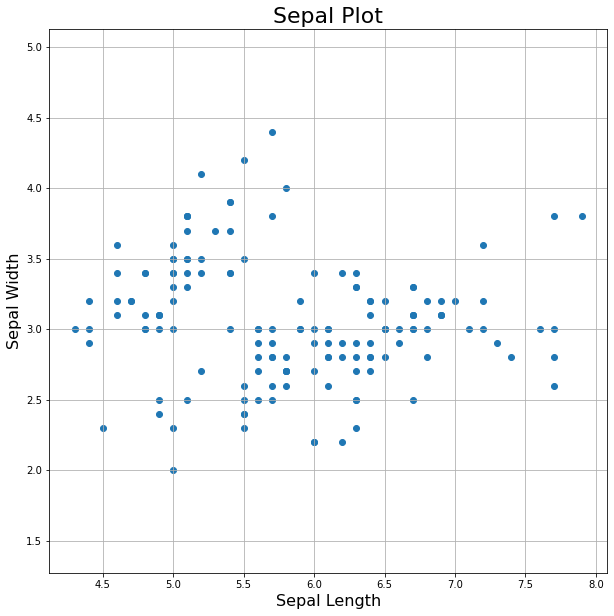

In [ ]:
plt.figure(figsize=(10,10))                                            
plt.scatter(list(df.iloc[:,0]), list(df.iloc[:,1]), marker='o')       
plt.axis('equal')                                                                 
plt.xlabel('Sepal Length', fontsize=16)                                                 
plt.ylabel('Sepal Width', fontsize=16)                                                 
plt.title('Sepal Plot', fontsize=22)                                            
plt.grid()                                                                         
plt.show()

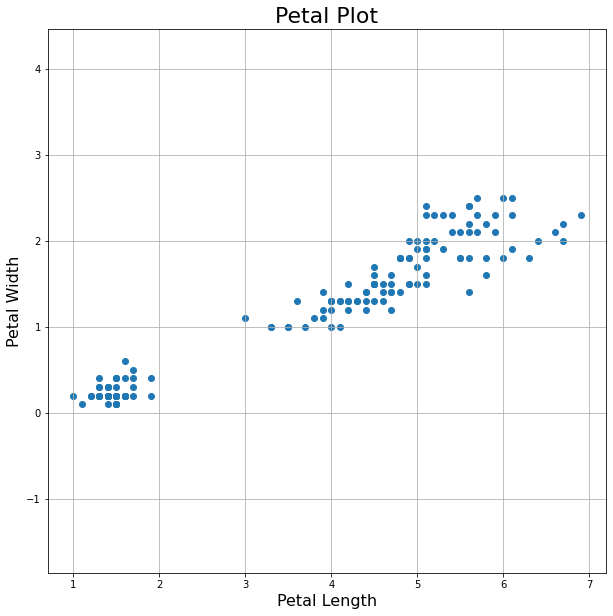

In [ ]:
plt.figure(figsize=(10,10))                                         
plt.scatter(list(df.iloc[:,2]), list(df.iloc[:,3]), marker='o')       
plt.axis('equal')                                                                 
plt.xlabel('Petal Length', fontsize=16)                                                 
plt.ylabel('Petal Width', fontsize=16)                                                 
plt.title('Petal Plot', fontsize=22)                                            
plt.grid()                                                                         
plt.show()

### **Calculating accuracy**

In [ ]:
#Calculating the accuracy
def accuracy(cluster_labels, class_labels):
    correct_pred = 0
    seto = max(set(labels[0:50]), key=labels[0:50].count)
    vers = max(set(labels[50:100]), key=labels[50:100].count)
    virg = max(set(labels[100:]), key=labels[100:].count)
    
    for i in range(len(df)):
        if cluster_labels[i] == seto and class_labels[i] == 'Iris-setosa':
            correct_pred = correct_pred + 1
        if cluster_labels[i] == vers and class_labels[i] == 'Iris-versicolor' and vers!=seto:
            correct_pred = correct_pred + 1
        if cluster_labels[i] == virg and class_labels[i] == 'Iris-virginica' and virg!=seto and virg!=vers:
            correct_pred = correct_pred + 1
            
    accuracy = (correct_pred/len(df))*100
    return accuracy

### **Initialize membership matrix**

In [ ]:
def initializeMembershipMatrix(): 
    membership_mat = []
    for i in range(n):

      # initializing the membership matrix with random values for 3 rows (3 clusters used)
      
        random_num_list = [random.random() for i in range(k)]
        summation = sum(random_num_list)
        temp_list = [x/summation for x in random_num_list]
        
        flag = temp_list.index(max(temp_list))
        for j in range(0,len(temp_list)):
            if(j == flag):
                temp_list[j] = 1
            else:
                temp_list[j] = 0
        
        membership_mat.append(temp_list)
    return membership_mat

In [ ]:
membership_mat = initializeMembershipMatrix()

### **Calculating Cluster Center**

In [ ]:
def calculateClusterCenter(membership_mat): 
    cluster_mem_val = list(zip(*membership_mat))
    cluster_centers = []
    for j in range(k):
        x = list(cluster_mem_val[j])

        # for each row in the initial membership matrix computing Vij (initial cluster center)
        # formula => summation[(Mu**m) * xkj] / summation((Mu**m)) 
        # m=> fuzzy parameter Mu=>value in membership matrix  and xkj=>is the data point

        xraised = [p ** m for p in x]
        denominator = sum(xraised)
        temp_num = []
        for i in range(n):
            data_point = list(df.iloc[i])
            prod = [xraised[i] * val for val in data_point]  # calculation of nuemerator
            temp_num.append(prod)
        numerator = map(sum, list(zip(*temp_num)))
        center = [z/denominator for z in numerator]
        cluster_centers.append(center)
    return cluster_centers

In [ ]:
#cluster_centers = calculateClusterCenter(membership_mat)
#['sepal length','sepal width','petal length','petal width']
calculateClusterCenter(membership_mat)

[[5.6625000000000005,
  3.1375000000000006,
  3.504166666666666,
  1.1541666666666663],
 [5.887037037037037,
  3.0500000000000003,
  3.783333333333333,
  1.1944444444444444],
 [5.974999999999999, 2.975000000000001, 3.985416666666667, 1.2479166666666661]]

### **Updating Membership Value**

In [ ]:
def updateMembershipValue(membership_mat, cluster_centers): 
    p = float(2/(m-1))
    for i in range(n):
        x = list(df.iloc[i])

        # find the distance between all the datapoints 
        distances = [np.linalg.norm(np.array(list(map(operator.sub, x, cluster_centers[j])))) for j in range(k)]
        
        # updating membership matrix 
        # Mu = summation[(dik/djk)**m]**-1

        for j in range(k):
            den = sum([math.pow(float(distances[j]/distances[c]), p) for c in range(k)])
            membership_mat[i][j] = float(1/den)       
    return membership_mat

### **Getting the clusters**

In [ ]:
# check the convergence criterion 
# max[Mu ik(1) - Mu ik(0)]

def getClusters(membership_mat):
    cluster_labels = list()
    for i in range(n):
        max_val, idx = max((val, idx) for (idx, val) in enumerate(membership_mat[i]))
        cluster_labels.append(idx)
    return cluster_labels

### **Fuzzy C-Means with cluster centres at the origin**

In [ ]:
def fuzzyCMeansClustering(): #First Iteration with centers at 0
    # Membership Matrix
    membership_mat = initializeMembershipMatrix()
    curr = 0
    acc=[]
    cent_temp = [[0, 0, 0, 0],[0, 0, 0, 0],[0, 0, 0, 0]]

    # here the stopping criterion is maximum iterations
    while curr < MAX_ITER:
        if(curr == 0):
            cluster_centers = cent_temp
            print("Cluster Centers:")
            print(np.array(cluster_centers))
        else:
            cluster_centers = calculateClusterCenter(membership_mat)
        membership_mat = updateMembershipValue(membership_mat, cluster_centers)
        cluster_labels = getClusters(membership_mat)
        acc.append(cluster_labels)
        curr += 1
    print("---------------------------")
    print("Membership Matrix:")
    print(np.array(membership_mat))
    return cluster_labels, cluster_centers, acc

### **Fuzzy C-Means with with cluster centers at random locations within a multi-variate Gaussian distribution with zero-mean and unit-variance.**

In [ ]:
def fuzzyCMeansClustering(): #Second Iteration Multivariate Gaussian
    # Membership Matrix
    membership_mat = initializeMembershipMatrix()
    curr = 0
    acc=[]
    mean = [0, 0]
    cov = [[1, 0], [0, 1]]
    
    lis1,cent_temp=[],[]
    
    for i in range(0,k):
        Z = list(np.random.multivariate_normal(mean, cov))
        Z1 = list(np.random.multivariate_normal(mean, cov))
        lis1 = Z+Z1
        cent_temp.append(lis1)
    
    
    while curr < MAX_ITER:
        if(curr == 0):
            cluster_centers = cent_temp
            print("Cluster Centers:")
            print(np.array(cluster_centers))
        else:
            cluster_centers = calculateClusterCenter(membership_mat)
        membership_mat = updateMembershipValue(membership_mat, cluster_centers)
        cluster_labels = getClusters(membership_mat)
        acc.append(cluster_labels)
        curr += 1
    print("---------------------------")
    print("Membership Matrix:")
    print(np.array(membership_mat))
    return cluster_labels, cluster_centers, acc

### **Fuzzy C-Means with cluster centers at random vectors chosen from the data.**

In [ ]:
def fuzzyCMeansClustering(): #Third iteration Random vectors from data
    # Membership Matrix
    membership_mat = initializeMembershipMatrix()
    curr = 0
    acc=[]
    while curr < MAX_ITER:
        cluster_centers = calculateClusterCenter(membership_mat)
        membership_mat = updateMembershipValue(membership_mat, cluster_centers)
        cluster_labels = getClusters(membership_mat)
        
        acc.append(cluster_labels)
        
        if(curr == 0):
            print("Cluster Centers:")
            print(np.array(cluster_centers))
        curr += 1
    print("---------------------------")
    print("Partition matrix:")
    print(np.array(membership_mat))
    #return cluster_labels, cluster_centers
    return cluster_labels, cluster_centers, acc

### **Calculating the Accuracy**

In [ ]:
labels, centers, acc = fuzzyCMeansClustering()
a = accuracy(labels, class_labels)

Cluster Centers:
[[5.91568627 3.02941176 3.90784314 1.2627451 ]
 [5.678      3.132      3.412      1.078     ]
 [5.93673469 3.         3.95714286 1.25510204]]
---------------------------
Partition matrix:
[[1.72424329e-04 9.99770794e-01 5.67819162e-05]
 [2.82446451e-03 9.96289054e-01 8.86481003e-04]
 [2.17929773e-03 9.97101689e-01 7.19013163e-04]
 [4.49283135e-03 9.94099369e-01 1.40779918e-03]
 [3.63741759e-04 9.99514701e-01 1.21557690e-04]
 [1.29758903e-02 9.82814052e-01 4.21005758e-03]
 [2.30718744e-03 9.96935703e-01 7.57109076e-04]
 [8.40484306e-06 9.99988930e-01 2.66508464e-06]
 [1.38351228e-02 9.81705950e-01 4.45892768e-03]
 [1.72962558e-03 9.97732122e-01 5.38252020e-04]
 [4.41894904e-03 9.94108059e-01 1.47299186e-03]
 [5.91849425e-04 9.99223933e-01 1.84218020e-04]
 [3.77067942e-03 9.95029147e-01 1.20017378e-03]
 [1.57289028e-02 9.78743610e-01 5.52748695e-03]
 [2.67674268e-02 9.62915366e-01 1.03172071e-02]
 [4.74741073e-02 9.34117495e-01 1.84083981e-02]
 [9.16970181e-03 9.87557694

In [ ]:
acc_lis = [] 
for i in range(0,len(acc)):
    val = accuracy(acc[i], class_labels)
    acc_lis.append(val)

### **Result**

In [ ]:
acc_lis = np.array(acc_lis) 
print("mean=",np.mean(acc_lis))
print("Std dev=",np.std(acc_lis))

mean= 88.43999999999997
Std dev= 2.278830109215401


In [ ]:
print("Accuracy = " + str(round(a, 2)))

Accuracy = 88.67


In [ ]:
print("Cluster center vectors:") 
print(np.array(centers))

Cluster center vectors:
[[5.8877322  2.75271885 4.36949728 1.40585918]
 [5.00525867 3.40761295 1.48051039 0.25084584]
 [6.80722429 3.05991213 5.68331178 2.06091097]]


### **Plotting the data**

In [ ]:
sepal_df = df_full.iloc[:,0:2]
sepal_df = np.array(sepal_df)

In [ ]:
#First initialization
#m1 = [0,0]
#m2 = [0,0]
#m3 = [0,0]
#Second initialization
#m1 = [-0.47534495, -0.16392118]
#m2 = [0.89019389, -1.19440781]
#m3 = [1.29107135, 0.48248487]
#Third initialization
m1 = random.choice(sepal_df)
m2 = random.choice(sepal_df)
m3 = random.choice(sepal_df)

cov1 = np.cov(np.transpose(sepal_df))
cov2 = np.cov(np.transpose(sepal_df))
cov3 = np.cov(np.transpose(sepal_df))

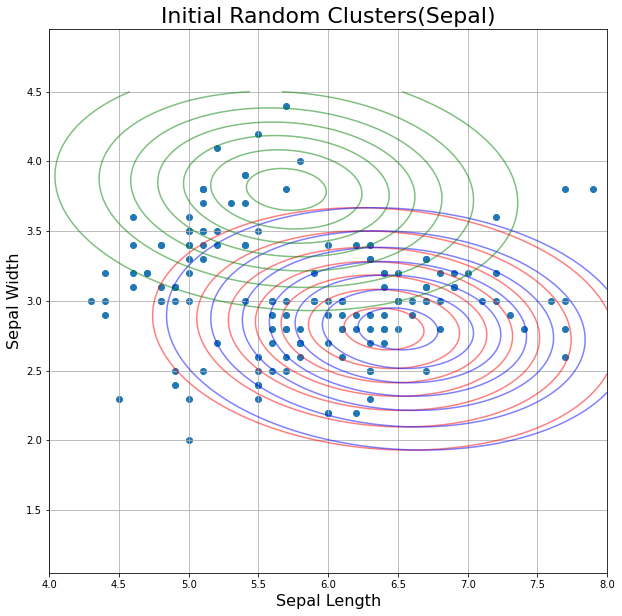

In [ ]:
x1 = np.linspace(4,8,150)  
x2 = np.linspace(1.5,4.5,150)
X, Y = np.meshgrid(x1,x2) 

Z1 = multivariate_normal(m1, cov1)  
Z2 = multivariate_normal(m2, cov2)
Z3 = multivariate_normal(m3, cov3)

pos = np.empty(X.shape + (2,))                # a new array of given shape and type, without initializing entries
pos[:, :, 0] = X; pos[:, :, 1] = Y   

plt.figure(figsize=(10,10))                                                          # creating the figure and assigning the size
plt.scatter(sepal_df[:,0], sepal_df[:,1], marker='o')     
plt.contour(X, Y, Z1.pdf(pos), colors="r" ,alpha = 0.5) 
plt.contour(X, Y, Z2.pdf(pos), colors="b" ,alpha = 0.5) 
plt.contour(X, Y, Z3.pdf(pos), colors="g" ,alpha = 0.5) 
plt.axis('equal')                                                                  # making both the axis equal
plt.xlabel('Sepal Length', fontsize=16)                                                  # X-Axis
plt.ylabel('Sepal Width', fontsize=16)                                                  # Y-Axis
plt.title('Initial Random Clusters(Sepal)', fontsize=22)                                            # Title of the plot
plt.grid()                                                                         # displaying gridlines
plt.show()

In [ ]:
petal_df = df_full.iloc[:,2:4]
petal_df = np.array(petal_df)

In [ ]:
#first initialization
#m1 = [0,0]
#m2 = [0,0]
#m3 = [0,0]
#second initialization
#m1 = [-0.8005044 , -0.7017542]
#m2 = [-2.17962154, -0.96475807]
#m3 = [-0.68988961,  0.54596565]
#third initialization
m1 = random.choice(petal_df)
m2 = random.choice(petal_df)
m3 = random.choice(petal_df)
cov1 = np.cov(np.transpose(petal_df))
cov2 = np.cov(np.transpose(petal_df))
cov3 = np.cov(np.transpose(petal_df))

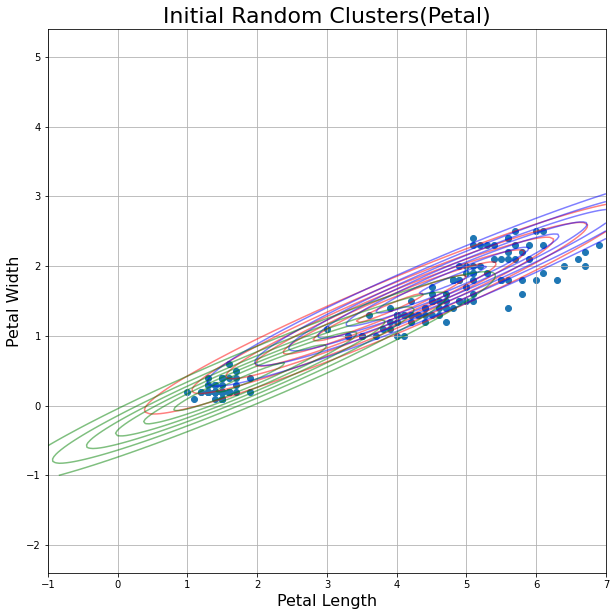

In [ ]:
x1 = np.linspace(-1,7,150)
x2 = np.linspace(-1,4,150)
X, Y = np.meshgrid(x1,x2) 

Z1 = multivariate_normal(m1, cov1)  
Z2 = multivariate_normal(m2, cov2)
Z3 = multivariate_normal(m3, cov3)

pos = np.empty(X.shape + (2,))                # a new array of given shape and type, without initializing entries
pos[:, :, 0] = X; pos[:, :, 1] = Y   

plt.figure(figsize=(10,10))                                                          # creating the figure and assigning the size
plt.scatter(petal_df[:,0], petal_df[:,1], marker='o')     
plt.contour(X, Y, Z1.pdf(pos), colors="r" ,alpha = 0.5) 
plt.contour(X, Y, Z2.pdf(pos), colors="b" ,alpha = 0.5) 
plt.contour(X, Y, Z3.pdf(pos), colors="g" ,alpha = 0.5) 
plt.axis('equal')                                                                  # making both the axis equal
plt.xlabel('Petal Length', fontsize=16)                                                  # X-Axis
plt.ylabel('Petal Width', fontsize=16)                                                  # Y-Axis
plt.title('Initial Random Clusters(Petal)', fontsize=22)                                            # Title of the plot
plt.grid()                                                                         # displaying gridlines
plt.show()

In [ ]:
#finding mode
seto = max(set(labels[0:50]), key=labels[0:50].count)
vers = max(set(labels[50:100]), key=labels[50:100].count)
virg = max(set(labels[100:]), key=labels[100:].count)

In [ ]:
#sepal
s_mean_clus1 = np.array([centers[seto][0],centers[seto][1]])
s_mean_clus2 = np.array([centers[vers][0],centers[vers][1]])
s_mean_clus3 = np.array([centers[virg][0],centers[virg][1]])

In [ ]:
values = np.array(labels) #label

#search all 3 species
searchval_seto = seto
searchval_vers = vers
searchval_virg = virg

#index of all 3 species
ii_seto = np.where(values == searchval_seto)[0]
ii_vers = np.where(values == searchval_vers)[0]
ii_virg = np.where(values == searchval_virg)[0]
ind_seto = list(ii_seto)
ind_vers = list(ii_vers)
ind_virg = list(ii_virg)

In [ ]:
sepal_df = df_full.iloc[:,0:2]

In [ ]:
seto_df = sepal_df[sepal_df.index.isin(ind_seto)]
vers_df = sepal_df[sepal_df.index.isin(ind_vers)]
virg_df = sepal_df[sepal_df.index.isin(ind_virg)]

In [ ]:
cov_seto = np.cov(np.transpose(np.array(seto_df)))
cov_vers = np.cov(np.transpose(np.array(vers_df)))
cov_virg = np.cov(np.transpose(np.array(virg_df)))

In [ ]:
sepal_df = np.array(sepal_df)

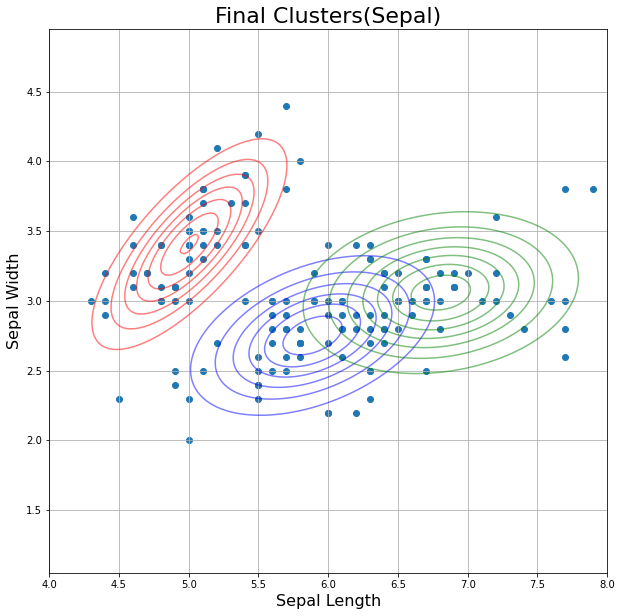

In [ ]:
x1 = np.linspace(4,8,150)  
x2 = np.linspace(1.5,4.5,150)
X, Y = np.meshgrid(x1,x2) 

Z1 = multivariate_normal(s_mean_clus1, cov_seto)  
Z2 = multivariate_normal(s_mean_clus2, cov_vers)
Z3 = multivariate_normal(s_mean_clus3, cov_virg)

pos = np.empty(X.shape + (2,))                # a new array of given shape and type, without initializing entries
pos[:, :, 0] = X; pos[:, :, 1] = Y   

plt.figure(figsize=(10,10))                                                          # creating the figure and assigning the size
plt.scatter(sepal_df[:,0], sepal_df[:,1], marker='o')     
plt.contour(X, Y, Z1.pdf(pos), colors="r" ,alpha = 0.5) 
plt.contour(X, Y, Z2.pdf(pos), colors="b" ,alpha = 0.5) 
plt.contour(X, Y, Z3.pdf(pos), colors="g" ,alpha = 0.5) 
plt.axis('equal')                                                                  # making both the axis equal
plt.xlabel('Sepal Length', fontsize=16)                                                  # X-Axis
plt.ylabel('Sepal Width', fontsize=16)                                                  # Y-Axis
plt.title('Final Clusters(Sepal)', fontsize=22)                                            # Title of the plot
plt.grid()                                                                         # displaying gridlines
plt.show()

In [ ]:
#petal
p_mean_clus1 = np.array([centers[seto][2],centers[seto][3]])
p_mean_clus2 = np.array([centers[vers][2],centers[vers][3]])
p_mean_clus3 = np.array([centers[virg][2],centers[virg][3]])

In [ ]:
petal_df = df_full.iloc[:,2:4]

In [ ]:
seto_df = petal_df[petal_df.index.isin(ind_seto)]
vers_df = petal_df[petal_df.index.isin(ind_vers)]
virg_df = petal_df[petal_df.index.isin(ind_virg)]

In [ ]:
cov_seto = np.cov(np.transpose(np.array(seto_df)))
cov_vers = np.cov(np.transpose(np.array(vers_df)))
cov_virg = np.cov(np.transpose(np.array(virg_df)))

In [ ]:
petal_df = np.array(petal_df)

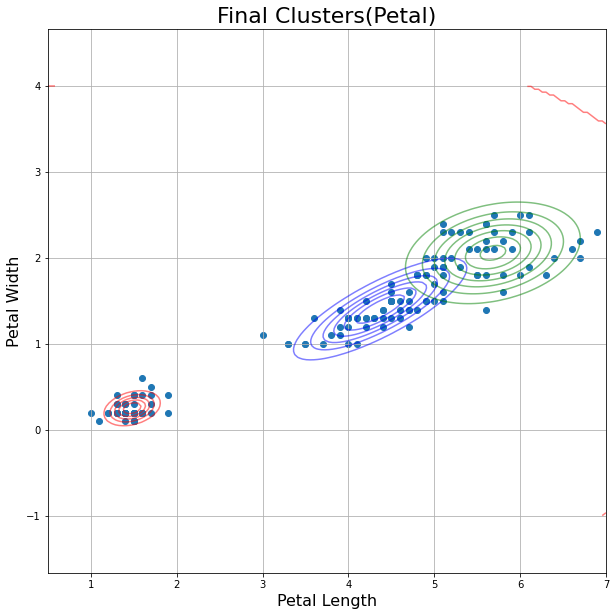

In [ ]:
x1 = np.linspace(0.5,7,150)  
x2 = np.linspace(-1,4,150)
X, Y = np.meshgrid(x1,x2) 

Z1 = multivariate_normal(p_mean_clus1, cov_seto)  
Z2 = multivariate_normal(p_mean_clus2, cov_vers)
Z3 = multivariate_normal(p_mean_clus3, cov_virg)

pos = np.empty(X.shape + (2,))                # a new array of given shape and type, without initializing entries
pos[:, :, 0] = X; pos[:, :, 1] = Y   

plt.figure(figsize=(10,10))                                                          # creating the figure and assigning the size
plt.scatter(petal_df[:,0], petal_df[:,1], marker='o')     
plt.contour(X, Y, Z1.pdf(pos), colors="r" ,alpha = 0.5) 
plt.contour(X, Y, Z2.pdf(pos), colors="b" ,alpha = 0.5) 
plt.contour(X, Y, Z3.pdf(pos), colors="g" ,alpha = 0.5) 
plt.axis('equal')                                                                  # making both the axis equal
plt.xlabel('Petal Length', fontsize=16)                                                  # X-Axis
plt.ylabel('Petal Width', fontsize=16)                                                  # Y-Axis
plt.title('Final Clusters(Petal)', fontsize=22)                                            # Title of the plot
plt.grid()                                                                         # displaying gridlines
plt.show()

### **Conclusion:**
#### The above program to implement Fuzzy C means clustering and visualize the clusters using scatter plot is implemented successfully and the output is noted